In [24]:
import cv2
import torch
import math
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torchvision.transforms as T
from skimage.util import random_noise
from collections import Counter as cpt

###### `LE MANQUE DE DONNEES`

L'une des raisons d'un surapprentissage est le manque de données. Dans un tel contexte, quelle que soit la quantité de données à disposition, ___un modèle recherchera toujours à extrait des caractéristiques, des schémas MÊME S'ILS N'EXISTENT PAS___.

Pour y remédier, une des stratégies les plus puissantes consiste à générer de __nouvelles données__ à partir de celles à disposition. Les avantages de l'augmentation de données sont nombreux. Implémenter correctement, l'augmentation de données permet de :

* réduire le coût d'acquisition et d'étiquetage des données 

* améliorer la généralisation du modèle en conférant plus de variété et de flexibilité au modèle

* amélioration de la précision du modèle dans la prédiction à mesure que davantage de données sont utilisées pour former le modèle

* réduire le surajustement des données

* gérer le déséquilibre dans l'ensemble de données en augmentant les échantillons de la classe minoritaire

##### AUGMENTATION D'IMAGES 
* ##### IDÉE GÉNÉRALE: Modifier les caractérisitques des images afin d'en produire de nouvelles.

Il existe de nombreuses librairies en python pour traiter les images:
 1. Pytorch
 2. Pillow
 3. Sci-kit image
 4. Opencv 
 5. Numpy (*À la différence des autres, il ne charge pas les images mais permet d'effectuer des calculs matriciels*)
 6. SciPy (`ndimage`)
 7. Albumentations

<span style='color:red '> Nous utiliserons certaines de ces librairies pour la manipulatins des images et illustrerons quelques différences. </span>

###### Chargement de l'image

In [2]:
img_path = "data/028copie-1copie-8.jpg"

In [3]:
img = Image.open(img_path)
impnp = np.asarray(img)

In [4]:
def _imshow(imgs, img_lab=[], bwith_orig=True):
    
    if not isinstance(imgs[0], list):
        imgs = [imgs]
    
    n_rows = len(imgs)
    n_cols = len(imgs[0])
    
    _, axs = plt.subplots(n_rows, n_cols, squeeze=False, figsize=(12,5))
    
    for row_idx, row in enumerate(imgs):
        for col_idx, im in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(im))
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
            if img_lab:
                ax.set(title='size: ' + str(im.size))
            ax.title.set_size(8)

* ##### Redimensionnement d'une l'image (Resizing)

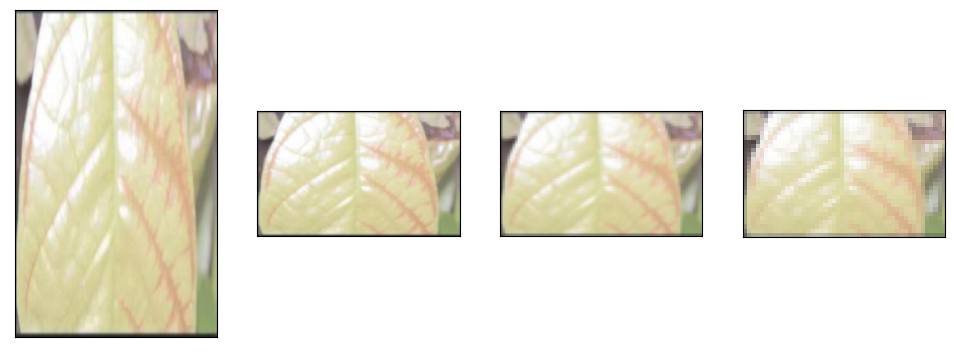

In [5]:
r_imgs = [T.Resize(size=size)(img) for size in (30, 50, 100, img.size)]
r_imgs = list(reversed(r_imgs))
_imshow(r_imgs)

Modifier la taille d'une image affecte la résolution de l'image. On a une bonne résolution avec une redimensionnement 100x100 et une mauvaise à 30x30.

* ##### Lissage par la moyenne (Normalisation)

In [6]:
img_path= "data/Capture_00001copie-15.jpg"
img = Image.open(img_path)

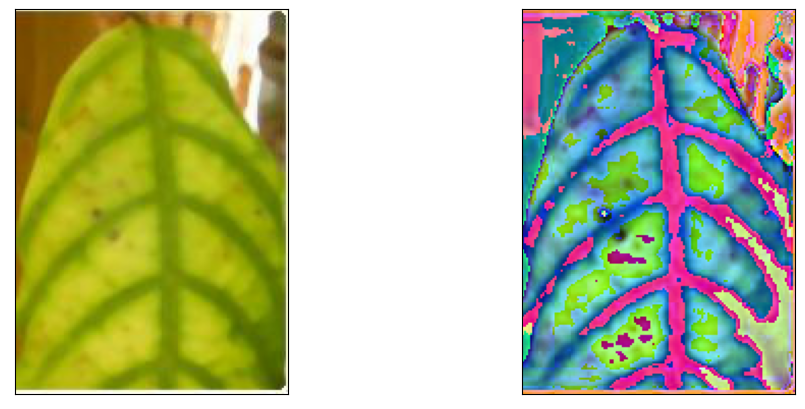

In [7]:
n_img = T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.3, 0.2])(T.ToTensor()(img)) 
n_img = [T.ToPILImage()(n_img)]
n_img.append(img)
n_imgs = list(reversed(n_img))
_imshow(n_imgs)

* ##### Translation d'une image

In [8]:
img_path= "data/06copie-10.jpg"
img = Image.open(img_path)

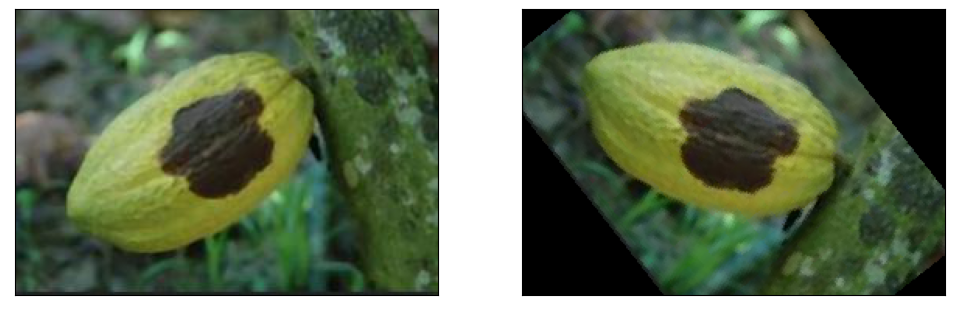

In [9]:
n_img = T.RandomAffine((30, 70))(T.ToTensor()(img))
n_img = [T.ToPILImage()(n_img)]
n_img.append(img)
n_imgs = list(reversed(n_img))
_imshow(n_imgs)

* ##### Rotation d'image

In [10]:
img_path = "data/C10copie-1.jpg"
img = Image.open(img_path)

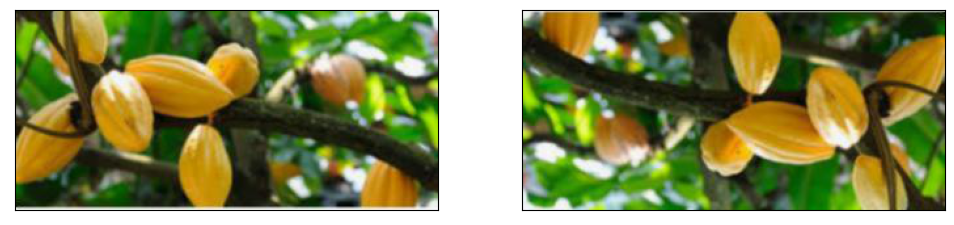

In [11]:
n_img = T.RandomRotation(degrees=(180, 180))(T.ToTensor()(img))
n_img = [T.ToPILImage()(n_img)]
n_img.append(img)
n_imgs = list(reversed(n_img))
_imshow(n_imgs)

* ##### Zoom sur une image

In [12]:
img_path = "data/C15copie-5.jpg"
img = Image.open(img_path)

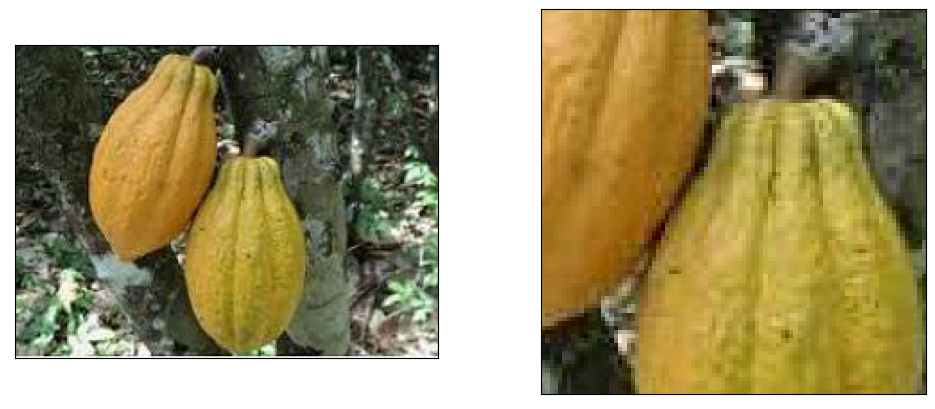

In [13]:
n_img = T.CenterCrop(size=90)(T.ToTensor()(img))
n_img = [T.ToPILImage()(n_img)]
n_img.append(img)
n_imgs = list(reversed(n_img))
_imshow(n_imgs)

`Pooling`

* ##### Max pooling

In [14]:
def get_pools(img: np.array, dim_pool: int, stride: int):
    pools = []
    

    for i in np.arange(img.shape[0], step=stride):
        
        for j in np.arange(img.shape[0], step=stride):
            
            mat = img[i:i+dim_pool, j:j+dim_pool]
            
            if mat.shape == (dim_pool, dim_pool):
                pools.append(mat)
                
    return np.array(pools)

In [15]:
def max_pooling(pools: np.array):

    nb_pools = pools.shape[0]
    
    shape_ = (int(np.sqrt(nb_pools)), int(np.sqrt(nb_pools)))
    
    pooled = []
    
    for pool in pools:
        pooled.append(np.max(pool))

    return np.array(pooled).reshape(shape_)

In [16]:
def plot_image(img: np.array):
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray');
    
def plot_two_images(img1: np.array, img2: np.array):
    _, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(img1)#, cmap='gray')
    ax[0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    ax[1].imshow(img2)#, cmap='gray');
    ax[1].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [17]:
img_path = "data/025copie-2.jpg"
img = Image.open(img_path)
grimg = ImageOps.grayscale(img)
grimg = grimg.resize(size=(224, 224))

In [18]:
cat_img_pools = get_pools(img=np.array(grimg), dim_pool=2, stride=1)
cat_max_pooled = max_pooling(pools=cat_img_pools)

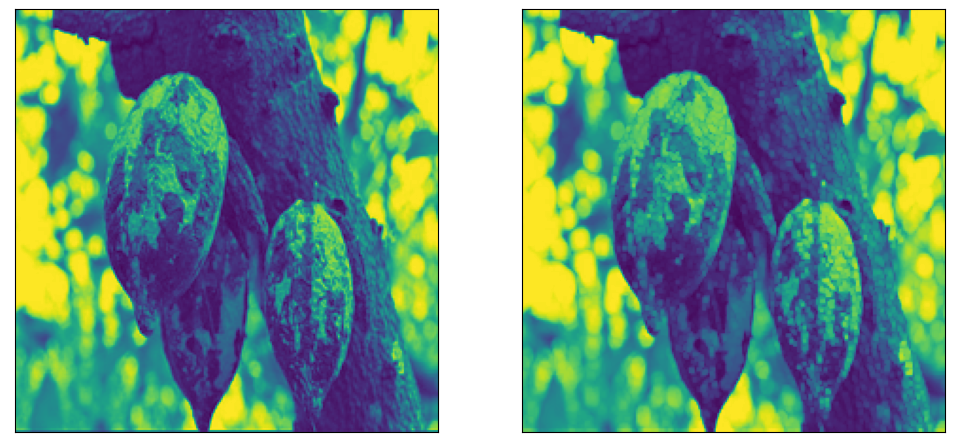

In [19]:
plot_two_images(img1=grimg, img2=cat_max_pooled)

* ##### Average pooling (Floutage d'image)

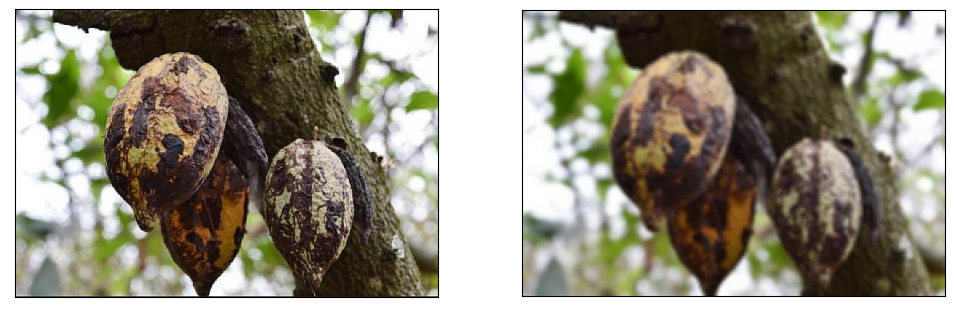

In [20]:
import torch
from PIL import Image
import torchvision.transforms as T

img_path = "data/025copie-2.jpg"
im = Image.open(img_path)
  
image = T.ToTensor()(im)
  
image = image.unsqueeze(0)

pooling = torch.nn.AvgPool2d(7, 3)
image = pooling(image)
  
image = image.squeeze(0)
  
n_img = [T.ToPILImage()(image)]
n_img.append(im)
n_imgs = list(reversed(n_img))
_imshow(n_imgs)

* ##### Flipping (Retournement)
<span style='color:red '> NB : Rotation vs Retournement </span> </p> 
`Le retournement d'une image est semblable à une image vue au travers d'un mirroir.`</p>
`La rotation est l'inclinaison de l'image autour d'un certain angle.`

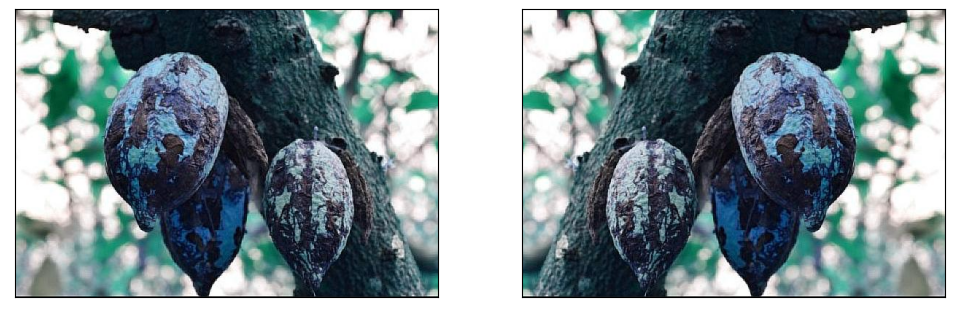

In [21]:
img = cv2.imread(img_path)
fimg = [cv2.flip(img, 2)]
fimg.append(img)
fimg = list(reversed(fimg))
_imshow(fimg)

* ##### Bruit Sel & Poivre (Salt and Pepper noise)
 Il s'agit de l'ajout de points blancs et noirs dans l'image. Il existe plusieurs types de bruits :
  * Le bruit Gaussien
  * Le bruit poissonnien
  * Le bruit de chatoiement (Speckle)

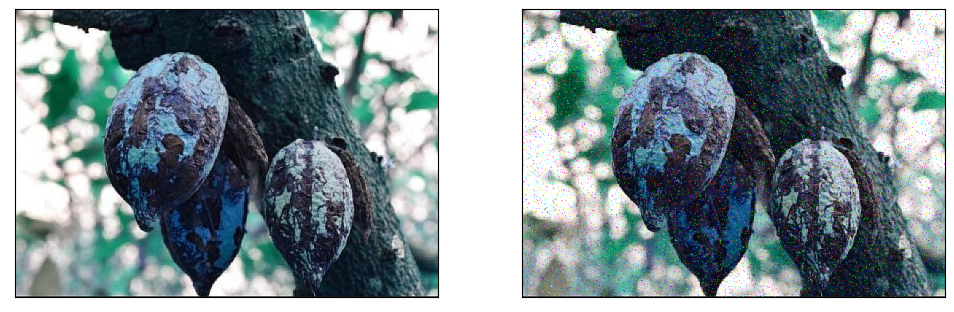

In [22]:
imgs = [img]
sp_img = random_noise(img, mode='s&p', clip=False)
imgs.append(sp_img)
_imshow(imgs)

* ##### Equalization (Egalisation d'histogramme)
`Améliore le contraste d'une image en étirant son histogramme.`

(0.0, 256.0)

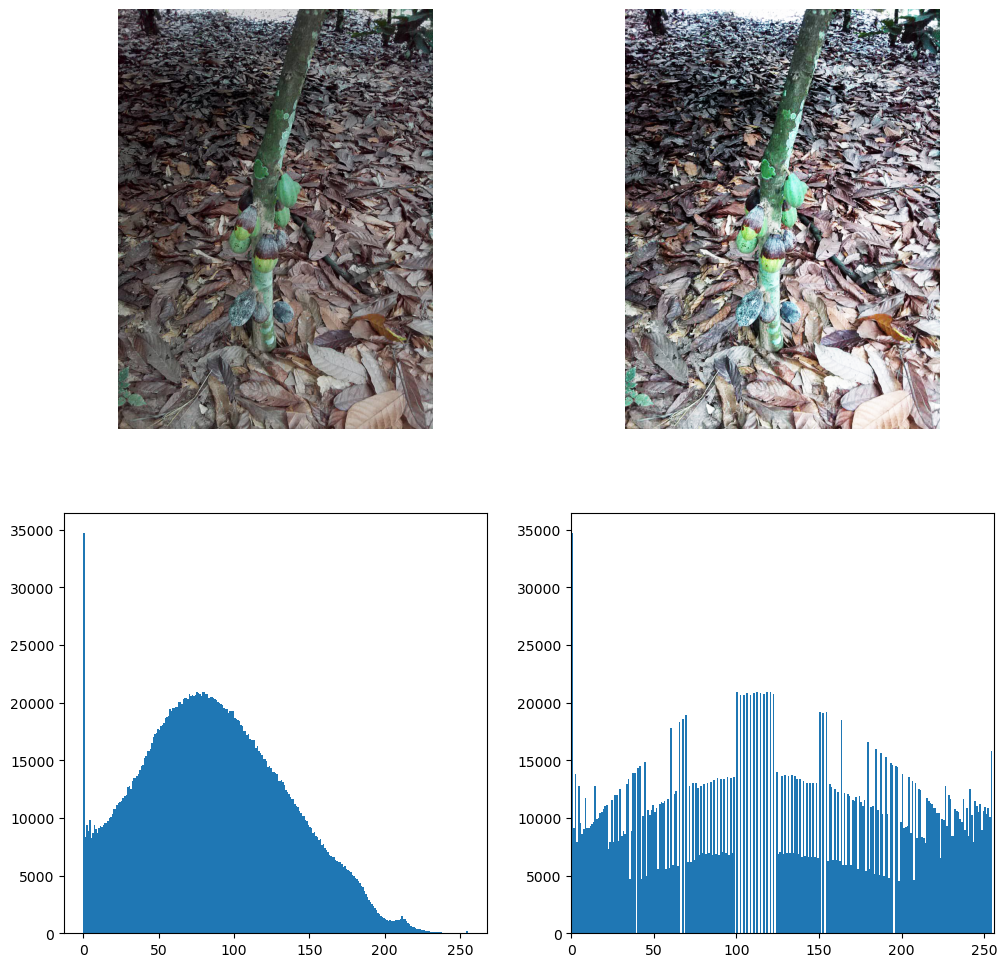

In [23]:
img_path = "data/IMG-136copie-2.jpg"
_, ax = plt.subplots(2, 2, squeeze=False, figsize=(12,12))

img = np.array(Image.open(img_path))
ax[0,0].imshow(img)
ax[0,0].axis('off')
ax[1,0].hist(img.flatten(), bins=range(256))

R, G, B = cv2.split(img)

output1_R = cv2.equalizeHist(R)
output1_G = cv2.equalizeHist(G)
output1_B = cv2.equalizeHist(B)

equ = cv2.merge((output1_R, output1_G, output1_B))
ax[0,1].imshow(equ)
ax[0,1].axis('off')
ax[1,1].hist(equ.flatten(), bins=range(256))
plt.xlim([0,256])

<p>
    
    
    
    
</p>

                                          Jacques Gnongui
                            VP of Software Engineering & Data scientist